<a href="https://colab.research.google.com/github/Prasad0505/Tweeter_Sentiment_Analysis_Project/blob/main/Tweeter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##What is Sentiment Analysis?

Sentiment analysis (also known as opinion mining) is one of the many applications of Natural Language Processing. It is a set of methods and techniques used for extracting subjective information from text or speech, such as opinions or attitudes. In simple terms, it involves classifying a piece of text as positive, negative or neutral.



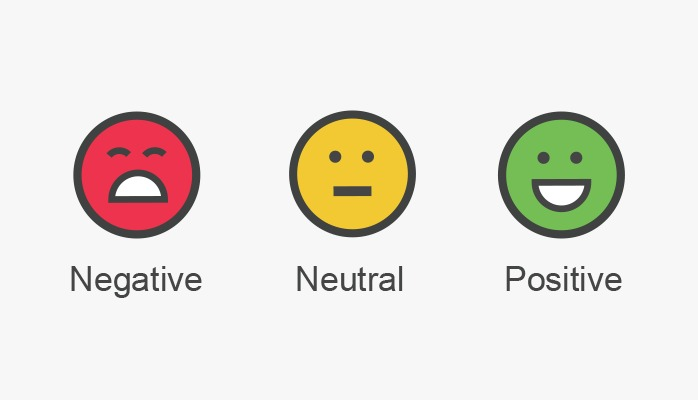

### **Problem Statement**

The problem statement is as follows:

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.
Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ denotes the tweet is not racist/sexist, your objective is to predict the labels on the labels on the given test dataset.

### **Importing Required Libraries And Importing Dataset**

In [ ]:
import re
import nltk
import string
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as pl
%matplotlib inline
pd.set_option("display.max_colwidth",200)
from keras.utils import to_categorical
from keras import models
from keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/train_tweets_data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test_tweets_data.csv")


### **Concatinate test data and train data**

In [ ]:
df = pd.concat([train_data,test_data],axis=0,ignore_index=True)
df

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation
...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦
49156,49157,NaN,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization"
49157,49158,NaN,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset"


### **Data Inspection**


Text is a highly unstructured form of data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing.

We will divide it into 2 parts:
* Data Inspection
* Data Cleaning

In [ ]:
df.shape

(49159, 3)

There are 49159 records and 3 features in our hole dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      49159 non-null  int64  
 1   label   31962 non-null  float64
 2   tweet   49159 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


THis dataset contain tweet as categorical and label as iteger value

In [ ]:
df["label"].value_counts()

0.0    29720
1.0     2242
Name: label, dtype: int64

This dataset contain 0 and 1 value in label(target) feature and have inbalance in nature in wich 0 is majority class and 1 is minority class

In [ ]:
length=train_data["length"]=train_data["tweet"].apply(lambda x:len(x))

### **Data Cleaning In NLP**

**1. converting text into lower case**

In [ ]:
#convert all letter in lower case
df["tweet"]= df['tweet'].apply(lambda x: " ".join(x.lower()  for x in x.split()))
df

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation
...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦
49156,49157,NaN,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization"
49157,49158,NaN,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset"


**2. Removing Tweeter Handels**

In [ ]:
def remove_pattern(input_text, pattern):
    """fuction to remove the tweeter handels
     data = df[tweet]"""
    r = re.findall(pattern, input_text)
    for i in r:
        input_text =  re.sub(i,"", input_text)
    return input_text

In [ ]:
df["tweet"]=np.vectorize(remove_pattern)(df["tweet"], "@[\w]*")
df

,id,label,tweet
0,1,0.0,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation
...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦
49156,49157,NaN,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization"
49157,49158,NaN,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset"


From the above function we remove the tweeter handels (@user) from tweet feature of the data set

**3. Punctuation Removal from tweet feature**

In [ ]:
df['tweet'] = df['tweet'].str.replace("[^a-zA-Z#]", " ")

<ipython-input-15-f0775bccaf37>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet'] = df['tweet'].str.replace("[^a-zA-Z#]", " ")


In [ ]:

df

,id,label,tweet
0,1,0.0,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ur
4,5,0.0,factsguide society now #motivation
...,...,...,...
49154,49155,NaN,thought factory left right polarisation #trump #uselections #leadership #politics #brexit #blm gt
49155,49156,NaN,feeling like a mermaid #hairflip #neverready #formal #wedding #gown #dresses #mermaid
49156,49157,NaN,#hillary #campaigned today in #ohio omg amp used words like assets amp liability never once did #clinton say thee word #radicalization
49157,49158,NaN,happy at work conference right mindset leads to culture of development organizations #work #mindset


By using string Punctuation we remove the All punctuation from the tweet feature of our dataset

**4. Stop Words Removal from dataset**

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
allstopwords = stopwords.words('english')
df["tweet"]= df["tweet"].apply(lambda x: " ".join(i for i in x.split() if i not in allstopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In our dataset many stopwords are available so we need remove all stop words and we remove it by downlaoding from nltk library  

In [ ]:
df5 = df.copy()

**5.Spelling Correction**

In [ ]:

#Install textblob library
! pip install textblob
from textblob import TextBlob

In [ ]:
# df["tweet"] = df["tweet"].apply(lambda x: str(TextBlob(x).correct()))

**6. Removing ShortWords from dataframe**

In [ ]:
#removing short words from tweet
df["tweet"] = df["tweet"].apply(lambda x: " ".join(i for i in x.split()if len(i)>3))

**7. Lemmatization**

In [ ]:
# # Download Wordnet through NLTK in python console:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
import textblob
from textblob import Word
df["tweet"]=df["tweet"].apply(lambda x: ",".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
df

,id,label,tweet
0,1,0.0,"father,dysfunctional,selfish,drag,kid,dysfunction,#run"
1,2,0.0,"thanks,#lyft,credit,cause,offer,wheelchair,van,#disapointed,#getthanked"
2,3,0.0,"bihday,majesty"
3,4,0.0,"#model,love,take,time"
4,5,0.0,"factsguide,society,#motivation"
...,...,...,...
49154,49155,NaN,"thought,factory,left,right,polarisation,#trump,#uselections,#leadership,#politics,#brexit,#blm"
49155,49156,NaN,"feeling,like,mermaid,#hairflip,#neverready,#formal,#wedding,#gown,#dresses,#mermaid"
49156,49157,NaN,"#hillary,#campaigned,today,#ohio,used,word,like,asset,liability,never,#clinton,thee,word,#radicalization"
49157,49158,NaN,"happy,work,conference,right,mindset,lead,culture,development,organization,#work,#mindset"


**8. Tokenization on dataset**

In [ ]:
df["tweet"]= df['tweet'].apply(lambda x: x.split())
df.head()

,id,label,tweet
0,1,0.0,"[father,dysfunctional,selfish,drag,kid,dysfunction,#run]"
1,2,0.0,"[thanks,#lyft,credit,cause,offer,wheelchair,van,#disapointed,#getthanked]"
2,3,0.0,"[bihday,majesty]"
3,4,0.0,"[#model,love,take,time]"
4,5,0.0,"[factsguide,society,#motivation]"


In [ ]:
for i in range(len(df["tweet"])):
    df["tweet"][i] = ' '.join(df["tweet"][i])


#combi['tweet'] = tokenized_tweet


<ipython-input-26-f13fa04ce2f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet"][i] = ' '.join(df["tweet"][i])


In [ ]:
df

,id,label,tweet
0,1,0.0,"father,dysfunctional,selfish,drag,kid,dysfunction,#run"
1,2,0.0,"thanks,#lyft,credit,cause,offer,wheelchair,van,#disapointed,#getthanked"
2,3,0.0,"bihday,majesty"
3,4,0.0,"#model,love,take,time"
4,5,0.0,"factsguide,society,#motivation"
...,...,...,...
49154,49155,NaN,"thought,factory,left,right,polarisation,#trump,#uselections,#leadership,#politics,#brexit,#blm"
49155,49156,NaN,"feeling,like,mermaid,#hairflip,#neverready,#formal,#wedding,#gown,#dresses,#mermaid"
49156,49157,NaN,"#hillary,#campaigned,today,#ohio,used,word,like,asset,liability,never,#clinton,thee,word,#radicalization"
49157,49158,NaN,"happy,work,conference,right,mindset,lead,culture,development,organization,#work,#mindset"


### **EDA and Visualization**

**1.WordCloud Graph on All Tweets**

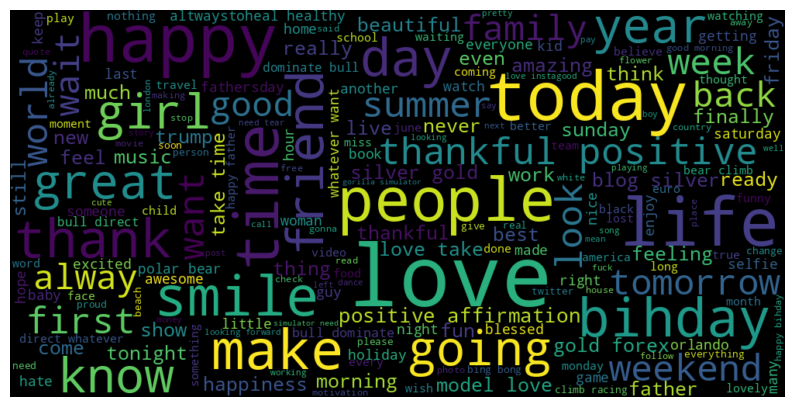

In [ ]:
import matplotlib.pyplot as plt
all_words = ' '.join([text for text in df['tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**2.Wordcloud Graph Racist/Sexist Tweets**

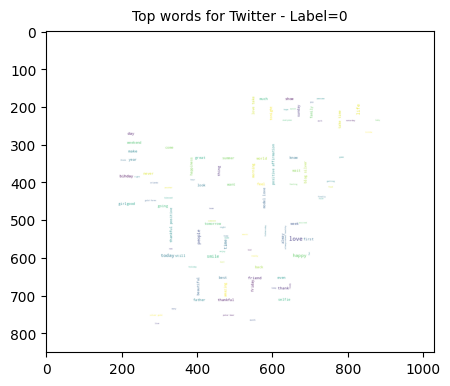

In [40]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/download (1).png')
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

twitter_mask = np.array(Image.open('/content/drive/MyDrive/download (1).png'))

wc = WordCloud(
    background_color='white',
    max_words=100,
    mask=twitter_mask
)

wc.generate(' '.join(text for text in df.loc[df['label'] == 0, 'tweet']))

plt.figure(figsize=(5, 7))
plt.title('Top words for Twitter - Label=0', fontdict={'size': 10, 'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.show()

**3. Understanding the impact of Hashtags on tweets sentiment**

In [41]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [42]:
# extracting hashtags from non racist/sexist tweets

HT_non_racist = hashtag_extract(df['tweet'][df['label'] == 0])

In [43]:
# extracting hashtags from racist/sexist tweets
HT_racist = hashtag_extract(df['tweet'][df['label'] == 1])

In [44]:
# unnesting list
HT_non_racist = sum(HT_non_racist,[])
HT_racist = sum(HT_racist,[])

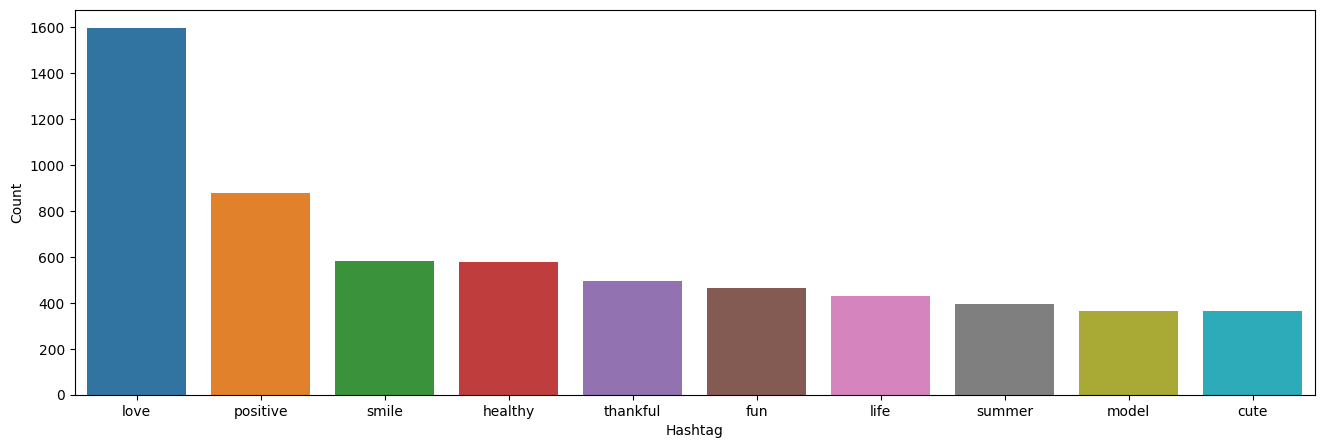

In [45]:
#Non-Racist/Sexist Tweets
a = nltk.FreqDist(HT_non_racist)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

**Observatation:**

1] trump word tweeted most of the time with # trend.

2] hate word tweeted mininmum time with # trend

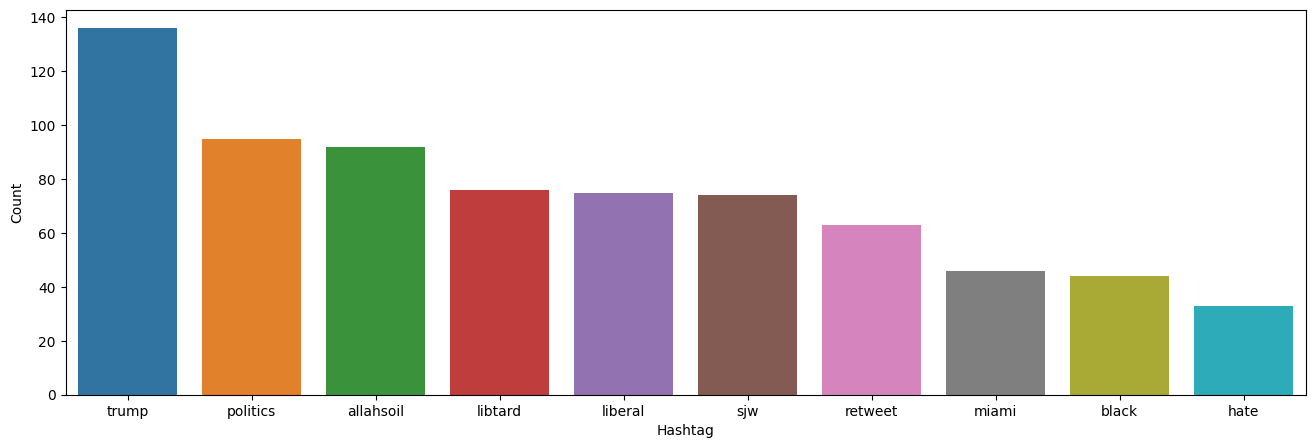

In [46]:

#Racist/Sexist Tweets

b = nltk.FreqDist(HT_racist)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

**obeservation**

1] trump word tweeted most of the time with # trend.

2] hate word tweeted mininmum time with # trend.

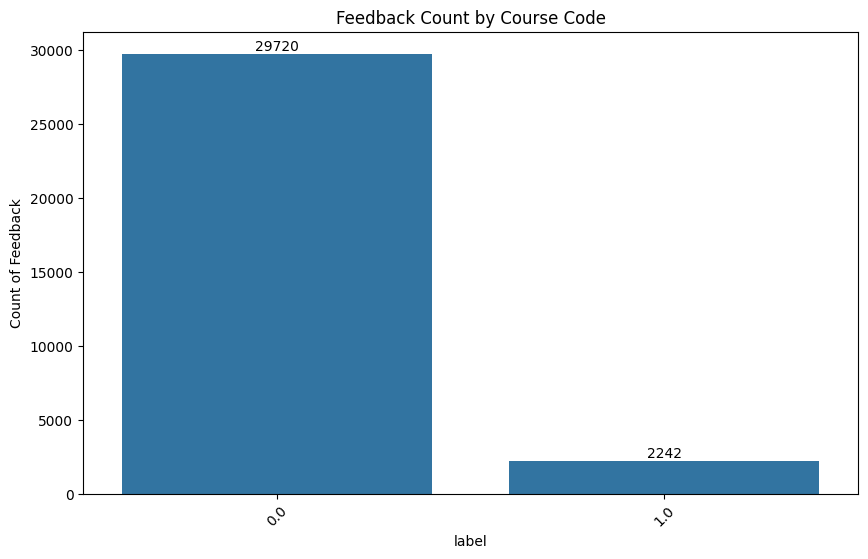

In [47]:
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
order = df['label'].value_counts().index
ax = sns.countplot(data=df, x='label', color=color, order=order)
plt.xlabel('label')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Code')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

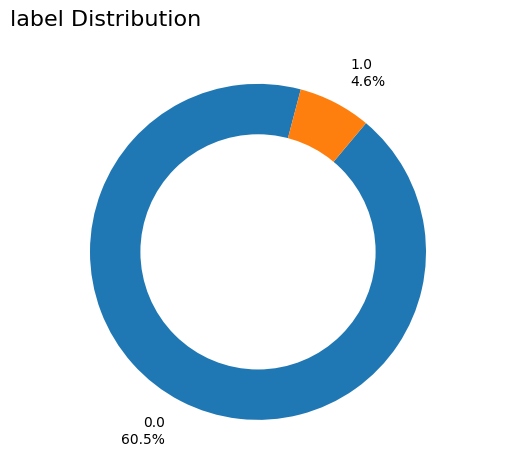

In [48]:
# Pie chart for Gender distribution
counts = df['label'].value_counts()
labels = [f"{label}\n{count / len(df) * 100:.1f}%" for label, count in counts.items()]
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('label Distribution', fontsize=16, loc='left', pad=30)
ax.axis('equal')
plt.show()

## **Extracting Features from Cleaned Tweets**

**1. Bag-of-Words Features**

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2,max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(df['tweet'])
bow_array = bow.toarray()
df1 = pd.DataFrame(data=bow_array,columns = bow_vectorizer.vocabulary_.keys())

In [50]:
df1.head()

,father,kid,run,thanks,cause,offer,bihday,model,love,time,...,nail,man,gif,fit,info,english,link,sound,trending,plus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
train_bow = df1.iloc[:31962,:]
test_bow = df1.iloc[31962:,:]

In [52]:
test_bow.shape

(17197, 1000)

In [53]:
type(train_bow)

pandas.core.frame.DataFrame

## **Data Balancing**


**By Upsampling**

In [54]:
train_df = pd.concat([train_bow,train_data["label"]],axis = 1)

In [55]:
train_df.head()

,father,kid,run,thanks,cause,offer,bihday,model,love,time,...,man,gif,fit,info,english,link,sound,trending,plus,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
train_df.shape

(31962, 1001)

In [57]:
df["label"].value_counts()

0.0    29720
1.0     2242
Name: label, dtype: int64

In [58]:
possitive_tweet = train_df[train_df["label"] == 1.0]
negative_tweet  = train_df[train_df["label"] == 0.0]

In [59]:
from sklearn.utils import resample
tweet_upsample = resample(possitive_tweet,n_samples=len(negative_tweet),random_state=42)

print(tweet_upsample.shape)

(29720, 1001)


In [60]:
from sklearn.utils import resample
tweet_upsample = resample(possitive_tweet,replace=True,n_samples=len(negative_tweet),random_state=42)

print(tweet_upsample.shape)

(29720, 1001)


0    29720
1    29720
Name: label, dtype: int64


<Axes: ylabel='Type'>

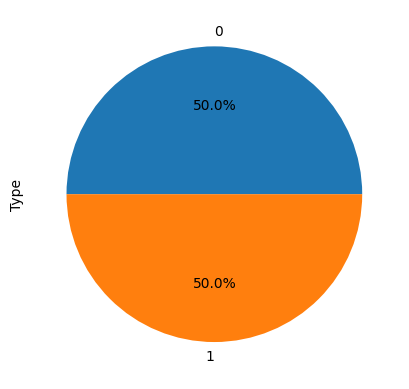

In [61]:
data_upsampled = pd.concat([negative_tweet, tweet_upsample])

print(data_upsampled["label"].value_counts())

data_upsampled.groupby('label').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.1f%%')

## **Model Fitting**

In [62]:
from sklearn.model_selection import train_test_split

x = data_upsampled.drop("label", axis='columns')
y = data_upsampled["label"]

# splitting data into training and validation set
#x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size=0.20)

In [63]:
# splitting data into training, testing and validation set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [64]:
# X_train.to_csv("x_train_csv",index = False)
# X_test.to_csv("x_test_csv", index = False)
# X_val.to_csv("x_val_csv", index = False)
# y_train.to_csv("y_train_csv", index = False)
# y_test.to_csv("y_test_csv", index = False)
# y_val.to_csv("y_val_csv", index = False)

In [65]:
# test_bow.to_csv("inferance_data", index = False)

**1.Logistic Regression by using Upsampling**



In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

x = data_upsampled.drop("label", axis='columns')
y = data_upsampled["label"]

# splitting data into training and validation set
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size=0.20)

lreg = LogisticRegression()
lreg.fit(x_train, y_train) # training the model
prediction = lreg.predict_proba(x_train)
prediction_int_train = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int_train = prediction_int_train.astype(np.int)

print(f1_score(y_train, prediction_int_train))

prediction = lreg.predict_proba(x_test) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(y_test, prediction_int) # calculating f1 score

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8772991151107521


<ipython-input-66-4f46bd502cbf>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int_train = prediction_int_train.astype(np.int)
<ipython-input-66-4f46bd502cbf>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

0.8782660332541569

**2. Random Forest**

In [68]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000,max_depth=100,random_state=0).fit(x_train, y_train)
train_pred = rf.predict(x_train)
prediction = rf.predict(x_test)
print(f1_score(y_train, train_pred))
print(f1_score(y_test, prediction))

KeyboardInterrupt: ignored

**Confussion Matrix On Test Data**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test,prediction)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['y_test', 'prediction'],
            yticklabels=['y_test', 'prediction'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


# Finding precision and recall
accuracy = accuracy_score(y_test, prediction)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, prediction)
print("Precision :", precision)
recall = recall_score(y_test,prediction)

**3. XGBoost Classifier**

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(max_depth=3, n_estimators=1000).fit(x_train, y_train)
train_pred = xgb_model.predict(x_train)
test_pred1 = xgb_model.predict(x_test)
print(f1_score(y_train, train_pred))
print(f1_score(y_test, test_pred1))


**4. Implementation of LightGBM Model**

In [ ]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import f1_score
lgm_train_pred = model.predict(x_train)
lgm_test_pred = model.predict(x_test)
print(f1_score(y_train, lgm_train_pred))
print(f1_score(y_test, lgm_test_pred))

### **5. DNN Implimentation**
**Building and Training the Neural Network**

There are two types of models available in keras: the Model Sequential API and the Functional API.

For more complex deep learning models, you should use the Functional API because Sequential API does not allow you to create models that share layers or have multiple inputs or outputs.

In [ ]:
#Set your model as the sequential model by running this command in a new cell:
model = models.Sequential()


**Creating Layers For Neural Network**


In [ ]:
# Input - Layer
model.add(layers.Dense(50, activation = "relu", input_shape=(1000, )))
# Hidden - Layers
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

**Model Compilation**

The compile() function defines the model architecture. You implement the adam algorithm as your model’s optimizer in this definition. This algorithm is a gradient descent method based on approximating first-order and second-order moments. The metrics and loss parameters are very closely related. While the metric parameter defines how to judge your model’s performance, the loss parameter defines the quantity that the model seeks to minimize during training. The metric here is accuracy (the fraction of predictions the model gets correctly), while the loss is binary_crossentropy (a metric between the labels and predictions used when there are only two label classes [the positive 1 and the negative 0]).

In [ ]:
model.compile(optimizer = "adam",loss = "binary_crossentropy",metrics = ["accuracy"])


**Model Traning With Neural Networks¶**

In [ ]:
results = model.fit(x_train,y_train,epochs= 3,batch_size = 32,validation_data = (X_val,y_val))

**Model Evaluation**

In [ ]:
scores=model.evaluate(x_train,y_train,verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
scores=model.evaluate(x_test,y_test,verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

**Model Prediction o inferance data**

In [ ]:
pred_infer = model.predict(test_bow)

In [ ]:
pred_infer